## Logistic regression with `pymc3`

Logistic regression is one of the simplest statistical models &mdash; and like many things in life, simple here is often synonymous with extremely powerful. I'm interested in the Bayesian statistics approach to it, here using Python. 

Here, let's learn how to do this basic task with `pymc3`, and notice if there are any gotchas worth mentioning.

### A note on `pymc4`
I started off this notebook by first wanting to try out `pymc4` (backed by Tensorflow instead of the deprecated Theano backend), which I thought was still in pre-release at the time. Turns out, development of `pymc4` has halted, and `pymc3` is the new black! That's great news in general, I think.

### Task
I'll be using a [small little dataset from Kaggle called `cycling.csv`](https://www.kaggle.com/dixienewsome/cycling). The plan is as folows:

1. We'll create an extra boolean column called `hr_zone_4` if the average heart rate hit the classic "Zone 4" training, commonly called lactate threshold.
2. Massage the rest of the data to create usable variables for regression
3. Perform the regression using `statsmodels` for benchmark
4. Perform the regression with `pymc4`!

Notice that our task is not very... important? or interesting? We should just consider it a way to get working data and see if we can detect patterns.

In [1]:
%matplotlib inline
import re

import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns

from sklearn import impute, preprocessing
import statsmodels.api as sm
from IPython.display import display

PLOT_STYLE = 'darkgrid'
sns.set_theme(style=PLOT_STYLE)
plt.style.use('seaborn-' +PLOT_STYLE)

# How many seconds per HH:MM:SS segment
SECONDS_MAP = {0: 1, 1: 60, 2: 60 * 60}
LOC = '~/data/cycling/cycling.csv'


def clean_column_names(col: str) -> str:
    fixed = col.strip().lower().replace(' ', '_').replace('(', '').replace(')', '').encode("ascii", "ignore").decode('utf-8')
    return fixed


def clean_timedelta_str(text: str) -> int:
    """Takes in dirty HH:MM:SS, returns seconds"""
    parts = text.replace('.', ':').split(':')
    
    # Times encoded with hunredths of a sec end with '00'
    if parts[-1] == '00':
        parts.pop()
    
    duration = 0
    for ix, part in enumerate(reversed(parts)):
        duration += SECONDS_MAP[ix] * int(part)
    return float(duration)

df = pd.read_csv(LOC, na_values='--', thousands=',', parse_dates=['Date'])
df.columns = [clean_column_names(col) for col in df.columns]
df['time'] = df['time'].apply(clean_timedelta_str)

# We don't care about anything under a mile (?) 
df = df[df['distance'] >= 1]

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 339
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   activity_type          300 non-null    object        
 1   date                   300 non-null    datetime64[ns]
 2   distance               300 non-null    float64       
 3   calories               300 non-null    float64       
 4   time                   300 non-null    float64       
 5   avg_hr                 279 non-null    float64       
 6   max_hr                 279 non-null    float64       
 7   avg_speed              300 non-null    float64       
 8   max_speed              300 non-null    float64       
 9   elev_gain              181 non-null    float64       
 10  elev_loss              185 non-null    float64       
 11  avg_bike_cadence       227 non-null    float64       
 12  max_bike_cadence       227 non-null    float64       
 13  norma

,activity_type,date,distance,calories,time,avg_hr,max_hr,avg_speed,max_speed,elev_gain,elev_loss,avg_bike_cadence,max_bike_cadence,normalized_power_np,training_stress_score,max_avg_power_20_min,power,max_power
0,indoor_cycling,2018-12-03 05:54:00,25.91,696.0,4595.0,164.0,180.0,20.3,23.9,NaN,NaN,89.0,102.0,158.0,66.8,163.0,152.0,404.0
1,road_biking,2018-12-02 13:47:00,20.81,679.0,4872.0,162.0,190.0,15.4,27.2,105.0,89.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,road_biking,2018-11-22 07:44:00,46.22,1158.0,10188.0,158.0,192.0,16.3,26.1,276.0,318.0,83.0,110.0,140.0,116.8,155.0,114.0,592.0
3,indoor_cycling,2018-11-18 08:36:00,23.27,634.0,4734.0,149.0,167.0,17.7,28.1,NaN,NaN,84.0,104.0,143.0,55.9,150.0,134.0,321.0
4,indoor_cycling,2018-11-18 07:29:00,12.21,512.0,3630.0,160.0,188.0,12.1,23.2,NaN,NaN,85.0,109.0,176.0,65.3,189.0,143.0,675.0


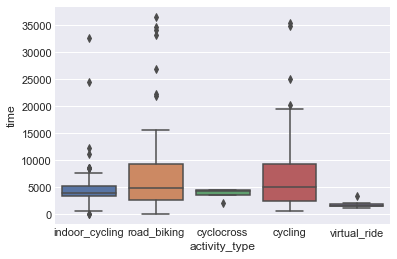

In [2]:
sns.boxplot(data=df, x='activity_type', y='time');

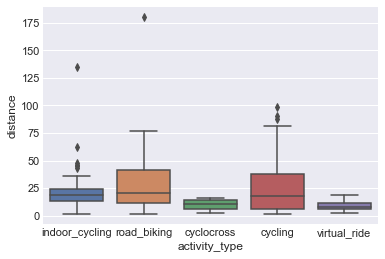

In [3]:
sns.boxplot(data=df, x='activity_type', y='distance');

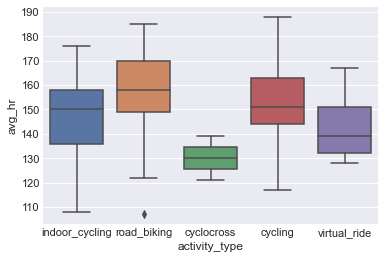

In [4]:
sns.boxplot(data=df, x='activity_type', y='avg_hr');

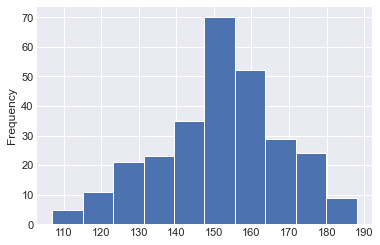

In [5]:
df['avg_hr'].plot.hist();

In [6]:
df['activity_type'].value_counts()

indoor_cycling    125
road_biking        95
cycling            70
virtual_ride        6
cyclocross          4
Name: activity_type, dtype: int64

### Target variable

Our target variable will be whether that training session was in Heart Rate Zone. This is otherwise known as Lactate Threshold training. It hurts.

>HEART RATE ZONE 4: 80–90% OF HRMAX
>If you train at this intensity, you’ll improve your speed endurance. Your body will get better at using carbohydrates for energy and you’ll be able to withstand higher levels of lactic acid in your blood for longer.

Given that:

>Most commonly, maximum heart rate is calculated by subtracting your age from 220. For a 30-year-old person, for example: `220 – 30 = 190`.

and that we also see have a maximum HR of 190 in the data, so this seems like a plausible number. 

In [7]:
TARGET_VARIABLE = 'zone_4'
MAX_HR = df['max_hr'].max()
LOWER_BOUND = 0.8 * MAX_HR
UPPER_BOUND = 0.9 * MAX_HR

df[TARGET_VARIABLE] = (df['avg_hr'] >= LOWER_BOUND) & (df['avg_hr'] <= UPPER_BOUND)
df[TARGET_VARIABLE] = df[TARGET_VARIABLE].astype(int)
df[TARGET_VARIABLE].value_counts()

0    288
1     12
Name: zone_4, dtype: int64

In [8]:
dummies = pd.get_dummies(df, columns=['activity_type'], prefix='activity')
for col in ['date']:
    del dummies[col]

dummies.corrwith(dummies[TARGET_VARIABLE])

distance                  -0.124073
calories                  -0.093106
time                      -0.124582
avg_hr                     0.388783
max_hr                     0.144816
avg_speed                  0.050706
max_speed                 -0.048281
elev_gain                 -0.051369
elev_loss                 -0.045157
avg_bike_cadence           0.084411
max_bike_cadence           0.079485
normalized_power_np        0.227881
training_stress_score     -0.138764
max_avg_power_20_min       0.138585
power                      0.261845
max_power                  0.182069
zone_4                     1.000000
activity_cycling           0.128698
activity_cyclocross       -0.023729
activity_indoor_cycling   -0.172516
activity_road_biking       0.080449
activity_virtual_ride     -0.029161
dtype: float64

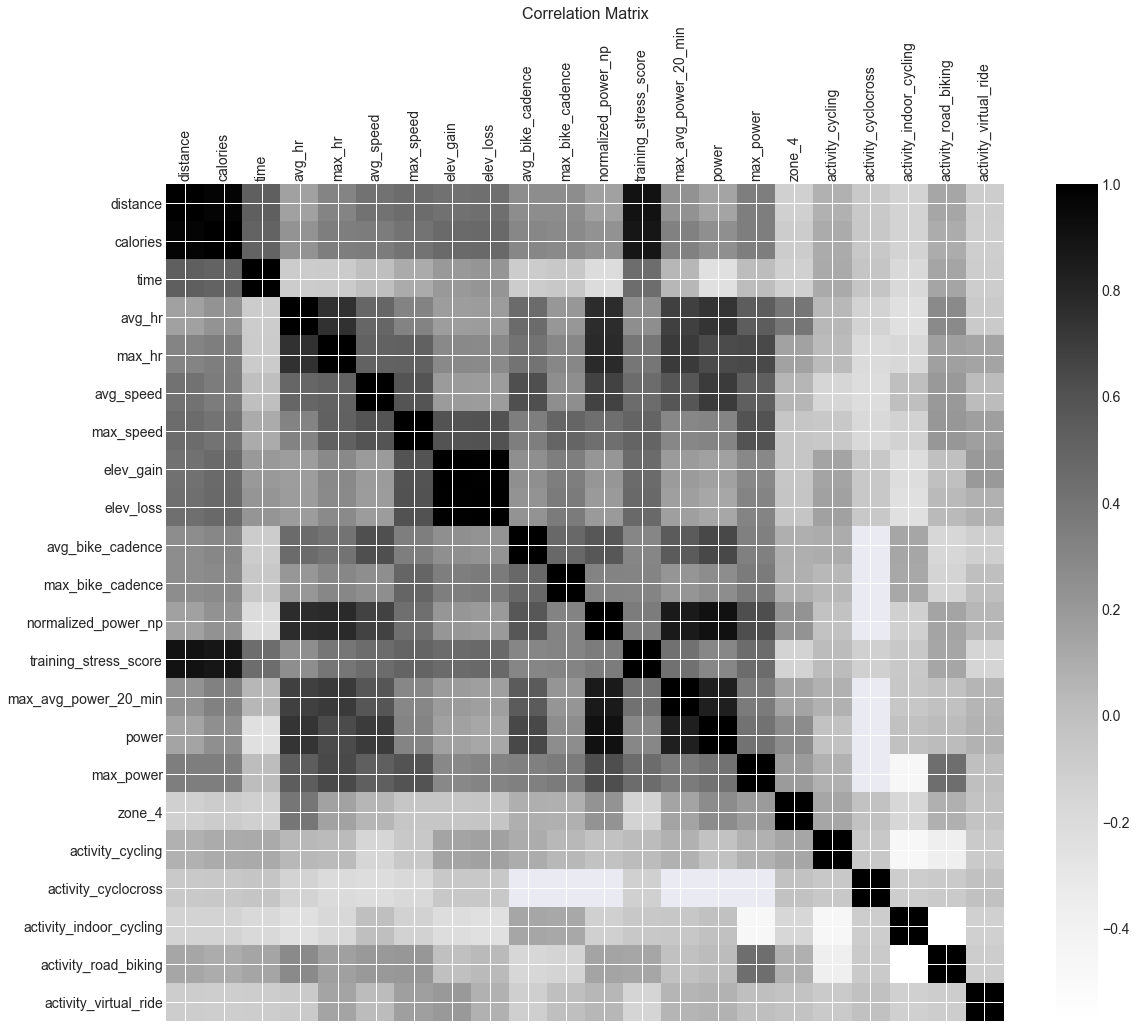

In [9]:
def correlation_plot(df):
    f = plt.figure(figsize=(19, 15))
    plt.matshow(df.corr(), fignum=f.number)
    plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
    plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16);
    plt.show()
    
    
correlation_plot(dummies)

So let's forget about:

* `date`, as it's useless
* `avg_hr`, as using heart rate is data leak,
* `max_hr`, as using heart rate is data leak,
* `elev_loss`, as it's almost perfectly correlated with `elev_gain`,
* `normalized_power_np`, as I don't know what it is,
* `training_stress_score`, as I don't know what it is,
* `max_avg_power_20_min` and `max_power`, as they're greatly correlated with `power`,
* `activity_type`, as it's irrelevant to our intended outcome, and
* `calories`, as it's almost perfectly correlated with distance.

## Benchmark – Logistic regression with `statsmodels`

In [10]:
from patsy import dmatrices

equation = 'zone_4 ~ distance + time + avg_speed + max_speed + elev_gain + avg_bike_cadence + power' 
y, X = dmatrices(equation, df, return_type = 'dataframe')

logistic_ss = sm.Logit(y, X)
results_ss = logistic_ss.fit()
results_ss.summary()

Optimization terminated successfully.
         Current function value: 0.075143
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 zone_4   No. Observations:                  128
Model:                          Logit   Df Residuals:                      120
Method:                           MLE   Df Model:                            7
Date:                Wed, 09 Dec 2020   Pseudo R-squ.:                  0.5445
Time:                        08:33:16   Log-Likelihood:                -9.6184
converged:                       True   LL-Null:                       -21.114
Covariance Type:            nonrobust   LLR p-value:                  0.001711
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -25.3625     22.570     -1.124      0.261     -69.599      18.874
distance            -0.1497      0.226     -0.663      0.507      -0.592       0.293
time             -9.144e-05      0.001     -0.125      0.900      -0.002       0.001
avg_speed            0.0158      0.727      0.022      0.983      -1.410       1.441
max_speed           -0.2663      0.290     -0.917      0.359      -0.835       0.303
elev_gain           -0.0005      0.003     -0.172      0.863      -0.006       0.005
avg_bike_cadence     0.2429      0.287      0.846      0.397      -0.320       0.806
power                0.0696      0.055      1.261      0.207      -0.039       0.178
====================================================================================

Possibly complete quasi-separation: A fraction 0.48 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

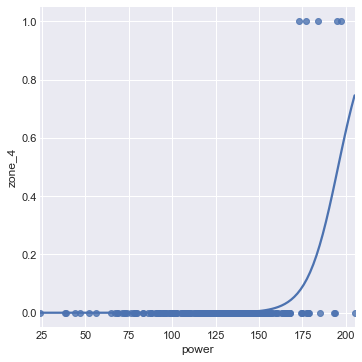

In [11]:
sns.lmplot(x='power', y='zone_4', data=df, logistic=True);

>**🛫 Digression**

So interestingly, this rider has a tendency to pedal faster (i.e. increase her bike cadence) when she's doing Zone 4 workouts!

One almost sure-fire way to increase your efficiency on a bike is to train to increase your [cadence in the sweet spot of 90-100 rpm in order to save your energy](https://blog.wahoofitness.com/cycling-cadence-what-is-it-how-to-improve-yours/#:~:text=So%20what's%20the%20ideal%20cadence,from%2080%20to%20100%20RPMs.).

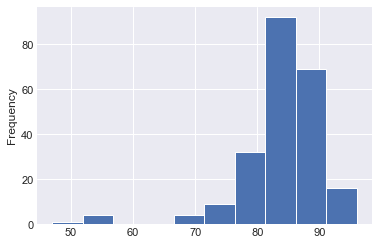

In [12]:
df['avg_bike_cadence'].plot.hist();

## Logistic regression with `pymc3`

In [13]:
with pm.Model() as model:
    pm_model = model
    pm.glm.GLM.from_formula(equation, df.dropna(), family=pm.glm.families.Binomial())
    trace = pm.sample(random_seed=123, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [power, avg_bike_cadence, elev_gain, max_speed, avg_speed, time, distance, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/leblancfg/src/github.com/leblancfg/leblancfg.github.io/env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


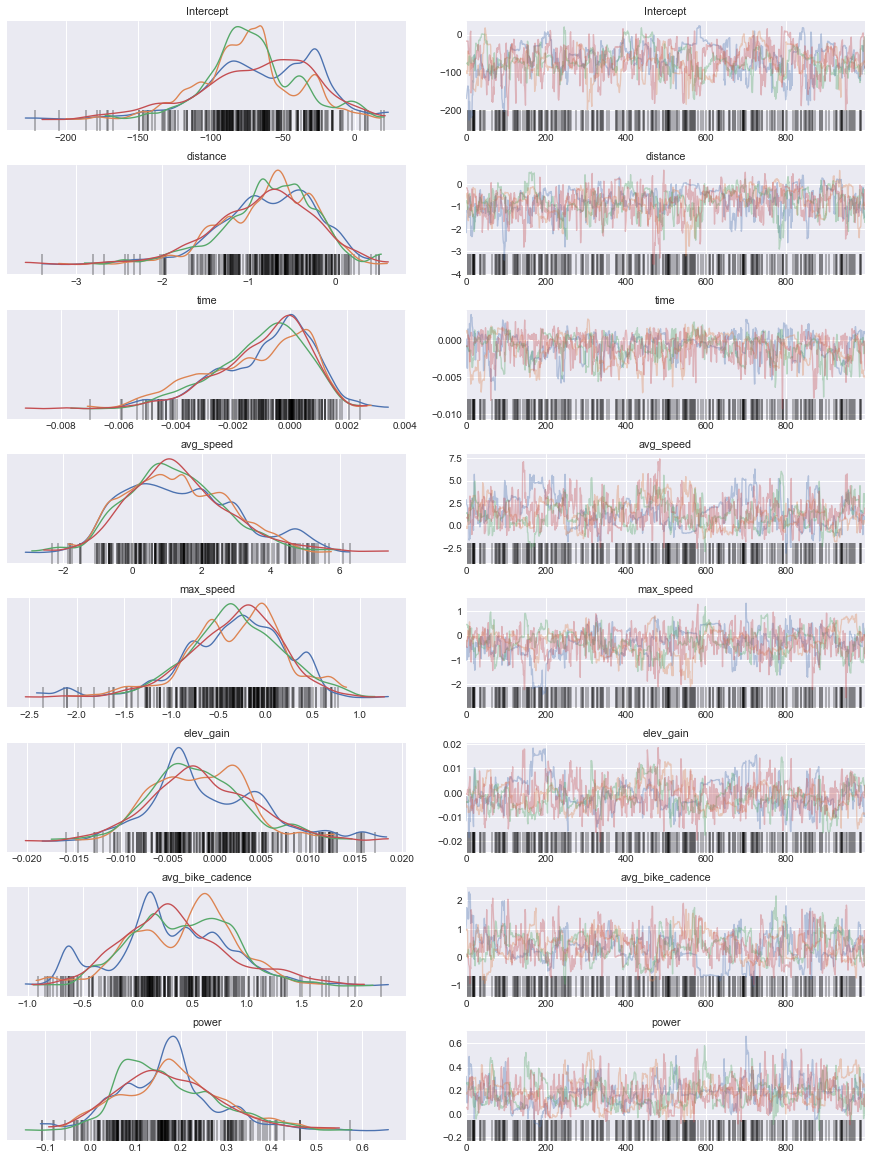

In [14]:
pm.plot_trace(trace);

In [15]:
az.from_pymc3(trace)

/Users/leblancfg/src/github.com/leblancfg/leblancfg.github.io/env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

As as aside, I have a fairly modern laptop, and I still can't believe how this trace took over 30 seconds to generate. 